# Desenvolvimento do Corona por UF
Esse trabalho mostra quantos dias demorou para cada estado ter seu desenvolvimento de casos.

In [1]:
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# Importing the Excel file with all the cities
covid_munic = pd.read_excel("cos_full_mun.xlsx")
covid_munic.head(1)

,COD_MUN,latitude,longitude,COD_UF,DS_MUN,DS_MESO,DS_UF,date,epidemiological_week,estimated_population_2019,...,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,1100015.0,-11.9283,-61.9953,11.0,Alta Floresta D'Oeste,Leste Rondoniense,Rondônia,2020-05-02,18,22945.0,...,1,435825.0,2020-05-02,0.0,0,1,city,RO,1,0


In [3]:
print("Last updated in: {:%d/%m/%Y}".format(max(covid_munic["date"])))

Last updated in: 13/05/2020


In [4]:
# We just need it by UF, so let's aggregate them
# Only leaving cases where we have at least one confirmed or one death
# And then create a cumulative frequency for confirmed cases and death 

covid_uf = covid_munic.groupby(["state", "date"])["new_confirmed", "new_deaths"].sum().reset_index()

covid_uf = covid_uf[(covid_uf["new_confirmed"] > 0) | (covid_uf["new_deaths"] > 0)]

covid_uf["date"] = pd.to_datetime(covid_uf['date'], format="%Y/%m/%d")

covid_uf['Cumulative Confirmed'] = covid_uf.groupby('state')['new_confirmed'].cumsum()
covid_uf['Cumulative Death'] = covid_uf.groupby('state')['new_deaths'].cumsum()
covid_uf.tail(2)

C:\Users\Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


,state,date,new_confirmed,new_deaths,Cumulative Confirmed,Cumulative Death
1654,TO,2020-05-10,59,1,747,12
1655,TO,2020-05-11,81,2,828,14


In [5]:
print("First date: {:%d/%m/%Y}".format(min(covid_uf["date"])))
print("Last updated in: {:%d/%m/%Y}".format(max(covid_uf["date"])))

First date: 25/02/2020
Last updated in: 13/05/2020


In [6]:
covid_uf.groupby("date")["state"].count().tail(5)

date
2020-05-09    25
2020-05-10    25
2020-05-11    27
2020-05-12    23
2020-05-13     3
Name: state, dtype: int64

In [7]:
# Because we only have 3 states on our last date, we will delete it
covid_uf = covid_uf[ covid_uf["date"] < max(covid_uf["date"])]
print("We have {} states with last updated in: {:%d/%m/%Y}".
      format(covid_uf[covid_uf["date"] == max(covid_uf["date"])] ["state"].count(), 
             max(covid_uf["date"])))

We have 23 states with last updated in: 12/05/2020


In [8]:
# Getting first cases in Brazil for confirmed and death
last_updated = max(covid_uf["date"])
first_br_confirmed = covid_uf[covid_uf["new_confirmed"] > 0]["date"].min()
first_br_death = covid_uf[covid_uf["new_deaths"] > 0]["date"].min()
print("First confirmed and death in Brasil: {:%d/%m/%Y} and {:%d/%m/%Y}".format(first_br_confirmed, first_br_death))

First confirmed and death in Brasil: 25/02/2020 and 17/03/2020


In [46]:
# Now let's get a summary for the UF
covid_uf_summary = covid_uf.groupby("state")["new_confirmed", "new_deaths"].sum().sort_values(by="new_confirmed", ascending = False)

covid_uf_summary["Date Case 1 in UF"] = covid_uf[covid_uf["new_confirmed"] > 0].groupby("state")["date"].min()
covid_uf_summary["Date first death in UF"] = covid_uf[covid_uf["new_deaths"] > 0].groupby("state")["date"].min()
covid_uf_summary["Dias entre Caso 1 brasileiro e Caso 1 na UF"] = (covid_uf_summary["Date Case 1 in UF"] - first_br_confirmed).dt.days
covid_uf_summary["Dias entre Caso 1 brasileiro e morte na UF"] = (covid_uf_summary["Date first death in UF"] - first_br_confirmed).dt.days

#Creating variables for each slice - YOU CAN CHANGE THOSE NUMBERS IF YOU WANT
cases_slice = [1, 100, 250, 500, 1000, 2000, 5000, 10000]
for s in range(1, len(cases_slice)):
    num_cases = cases_slice[s]
    num_cases_pre = cases_slice[s-1]
    covid_uf_summary["Date Case {} in UF".format(str(num_cases
                                                    ))] = covid_uf[covid_uf["Cumulative Confirmed"] > 
                                                                   num_cases].groupby("state")["date"].min()
    covid_uf_summary["Dias entre Caso {} e {} na UF".format(
        str(num_cases_pre), str(num_cases))] = (covid_uf_summary["Date Case {} in UF".format(str(num_cases
                                                    ))] - covid_uf_summary["Date Case {} in UF".format(str(num_cases_pre
                                                    ))]).dt.days
    

covid_uf_summary.tail(2)

C:\Users\Camila\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,new_confirmed,new_deaths,Date Case 1 in UF,Date first death in UF,Dias entre Caso 1 brasileiro e Caso 1 na UF,Dias entre Caso 1 brasileiro e morte na UF,Date Case 100 in UF,Dias entre Caso 1 e 100 na UF,Date Case 250 in UF,Dias entre Caso 100 e 250 na UF,Date Case 500 in UF,Dias entre Caso 250 e 500 na UF,Date Case 1000 in UF,Dias entre Caso 500 e 1000 na UF,Date Case 2000 in UF,Dias entre Caso 1000 e 2000 na UF,Date Case 5000 in UF,Dias entre Caso 2000 e 5000 na UF,Date Case 10000 in UF,Dias entre Caso 5000 e 10000 na UF
state,,,,,,,,,,,,,,,,,,,,
MT,604,20,2020-03-20,2020-04-03,24,38,2020-04-09,20,2020-04-27,18,2020-05-09,12.0,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
MS,405,12,2020-03-14,2020-03-31,18,35,2020-04-12,29,2020-04-30,18,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN


In [47]:
columns_for_graph = [k for k in list(covid_uf_summary.columns)  if 'Dias entre Caso' in k]
columns_for_graph.remove('Dias entre Caso 1 brasileiro e morte na UF')
print(columns_for_graph[::-1])

['Dias entre Caso 5000 e 10000 na UF', 'Dias entre Caso 2000 e 5000 na UF', 'Dias entre Caso 1000 e 2000 na UF', 'Dias entre Caso 500 e 1000 na UF', 'Dias entre Caso 250 e 500 na UF', 'Dias entre Caso 100 e 250 na UF', 'Dias entre Caso 1 e 100 na UF', 'Dias entre Caso 1 brasileiro e Caso 1 na UF']


In [48]:
# Function to add the label
def labeling():
    
    for rect in ax.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        # The width of the bar is the data value and can used as the label
        label_text = f'{width:.0f}'  # f'{height:.2f}' to format decimal values
        
        if np.isnan(x) == False and np.isnan(y) == False and width > 0:
            # ax.text(x, y, text)
            label_x = x + width - 0.2  # adjust 0.2 to center the label
            label_y = y + height / 2
            ax.text(label_x, label_y, label_text, ha='right', va='center', fontsize=9, color='white', fontname='MS Gothic')

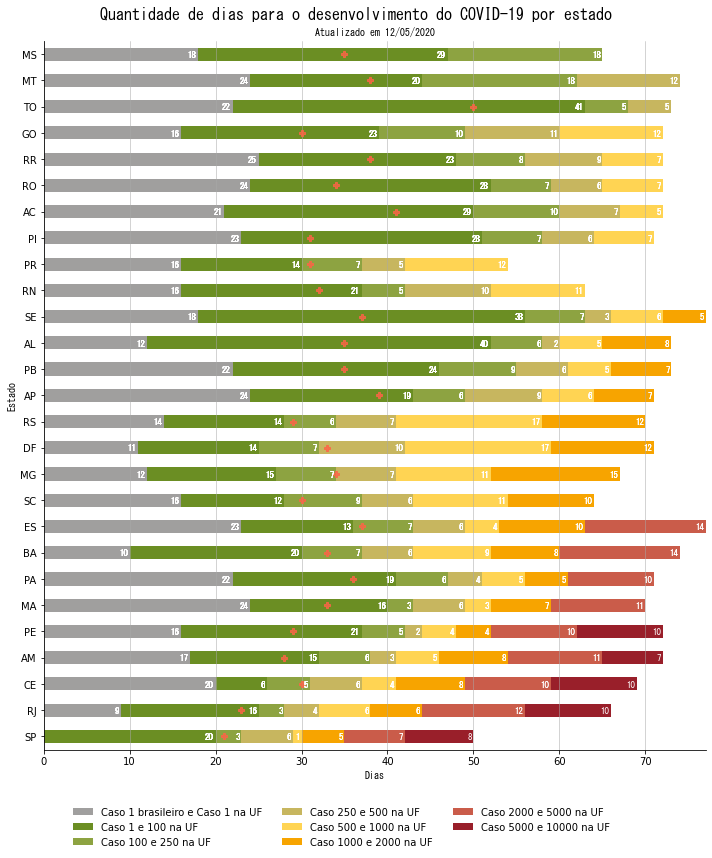

In [49]:
# Taken from here: https://pstblog.com/2016/10/04/stacked-charts
# But changed to a barh

fig, ax = plt.subplots(figsize=(10,12))

margin_bottom = np.zeros(len(covid_uf_summary.reset_index()['state'].drop_duplicates()))
# colors = ["#8B0000", "#B22222","#DC143C", "#CD5C5C", "#F08080", "#E9967A", "#FA8072", "#FFA07A"][::-1]
# colors = ["#006400", "#6B8E23", "#8da341", "#c7b65f", "#FFA07A", "#e57155", "#DC143C", "#8B0000"]
colors = ["#A09F9E", "#6B8E23", "#8da341", "#c7b65f", "#FFD453", "#F7A400", "#CA5C4A", "#991f2a"]

# Creating the stacked bars
for num, month in enumerate(columns_for_graph[::-1]):
    
    rects = covid_uf_summary.reset_index().plot.barh(x="state",y=columns_for_graph[num], ax=ax, stacked=True, 
                                    left = margin_bottom, color=colors[num], 
                                    label=str(columns_for_graph[num]).replace("Dias entre ", "") )
    labeling()
    margin_bottom += covid_uf_summary[columns_for_graph[num]]

# Adding the 1st deaths
plt.plot(covid_uf_summary["Dias entre Caso 1 brasileiro e morte na UF"], covid_uf_summary.reset_index()["state"]
         , marker="P", linestyle="", alpha=0.8, color="#FF6347")

# Taking out boarders and grid - Changing color of grid and background
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(color='#A9A9A9', axis = 'x', linewidth=0.5)
ax.set_facecolor('white') # #696969

# Adding legend on the bottom
plt.legend(bbox_to_anchor=(0.45, -0.15), ncol=3, loc='lower center'
           , facecolor = 'white', frameon=False)

# Getting titles rigth
plt.suptitle('Quantidade de dias para o desenvolvimento do COVID-19 por estado', fontsize=16, fontname='MS Gothic')
plt.title('Atualizado em {:%d/%m/%Y}'.format(last_updated), fontsize=10, fontname='MS Gothic')
plt.ylabel('Estado', fontname='MS Gothic')
plt.xlabel('Dias', fontname='MS Gothic')

# Final touch
fig.tight_layout()
fig.subplots_adjust(top=0.94)

# plt.show()
plt.savefig('Desenvolvimento do Covid por estado.png')